In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_data(path):
    imgs, lbls = zip(*[ (os.path.join(path, label, image), label)
                for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                    for image in os.listdir(os.path.join(path, label))
    ])
    return pd.DataFrame({
        "Image": imgs,
        "Class": lbls
    })

In [3]:
train = load_data("./Dataset/Training")
test = load_data("./Dataset/Testing")

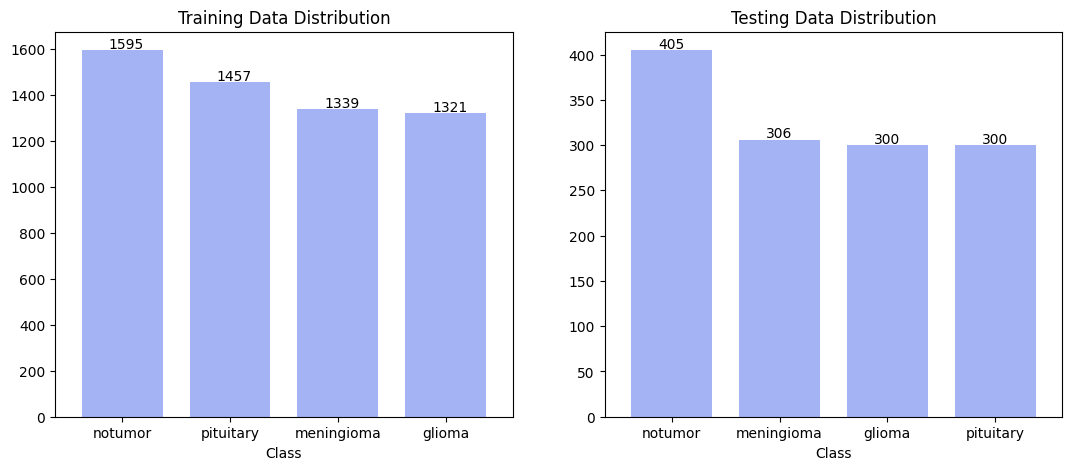

In [4]:
plt.figure(figsize=(13, 5))

for i, df in enumerate([train, test]):
    plt.subplot(1, 2, i+1)
    df["Class"].value_counts().plot.bar(width=0.75, color='#A3B3F3')
    plt.title(f"{'Training' if i==0 else 'Testing'} Data Distribution")
    plt.xticks(rotation=0)
    h = max(df["Class"].value_counts())
    for i, v in enumerate(df['Class'].value_counts()):
        plt.text(i-0.125, v+h/200, str(v))

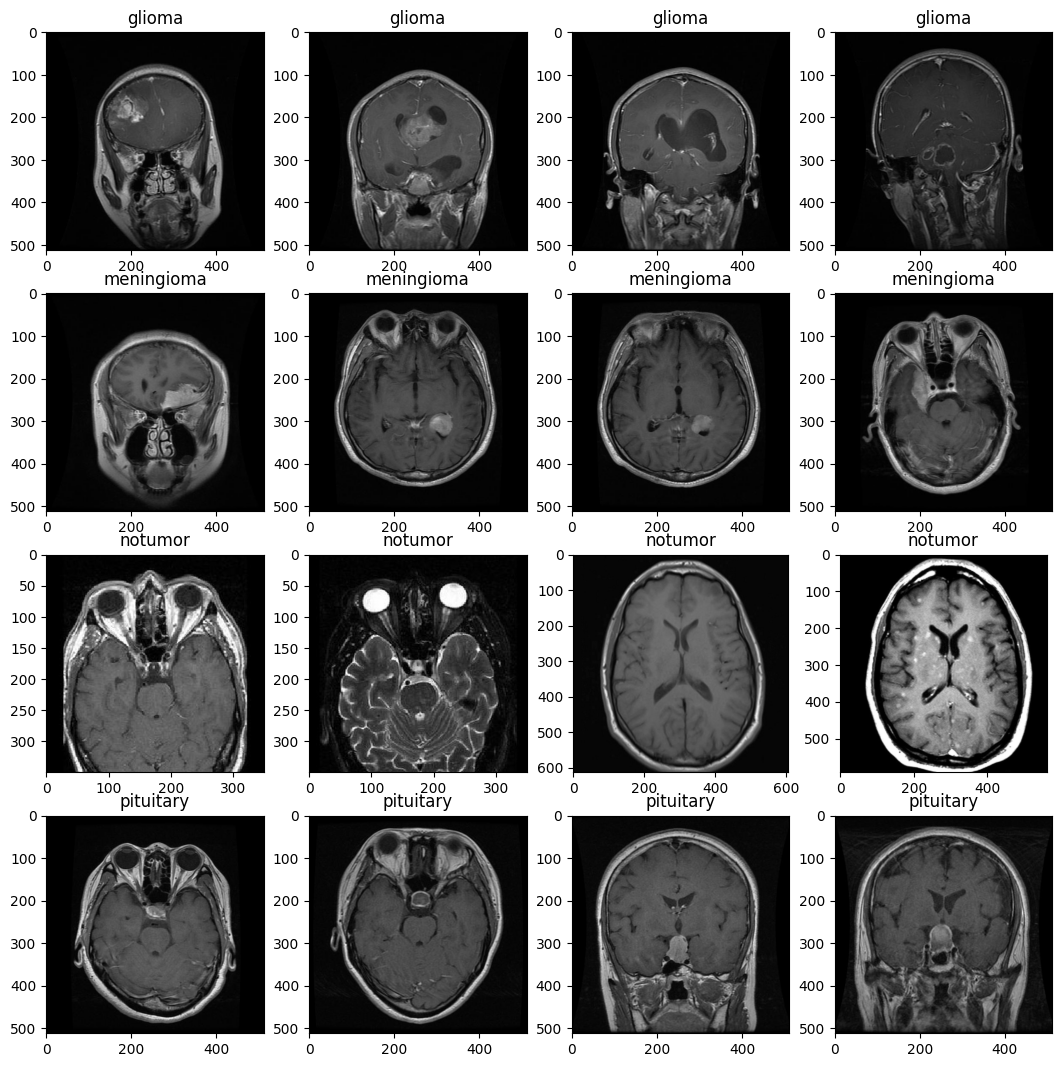

In [5]:
plt.figure(figsize=(13, 13))

for i, lbl in  enumerate(train['Class'].unique()):
    for j, im in enumerate(train[train['Class'] == lbl]['Image'][:4]):
        plt.subplot(4, 4 , i*4+j+1)
        plt.imshow(Image.open(im))
        plt.title(lbl)

In [6]:
from sklearn.model_selection import train_test_split

test, valid = train_test_split(test, test_size=0.5, stratify=test['Class'])

In [7]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5820)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', brightness_range=(0.8, 1.2)
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Image',
    y_col='Class',
    target_size=(299,299),
    batch_size=16,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='Image',
    y_col='Class',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image',
    y_col='Class',
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical'
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [10]:
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

img_shape =(299, 299, 3)


base_model = Xception(include_top=False,  weights="imagenet", input_shape= img_shape, pooling='max')


# for layer in base_model.layers[:-2]:
#     layer.trainable = False

base_model.layers[-1].activation = None

x = base_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)



model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [11]:
from keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = "Models/Xception/wave_2/model_epoch_{epoch:02}.keras",
    save_weights_only = False,
    save_best_only = False,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 0
)

In [14]:
import tensorflow.keras.backend as K
K.clear_session()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20, batch_size=16,
    callbacks = [checkpoint]
)

# Summmarizing

In [1]:
hist = history.history

NameError: name 'history' is not defined

In [22]:
import json
with open(r'Models\Xception\wave_2\Training.json', 'r') as f:
    hist = json.load(f)

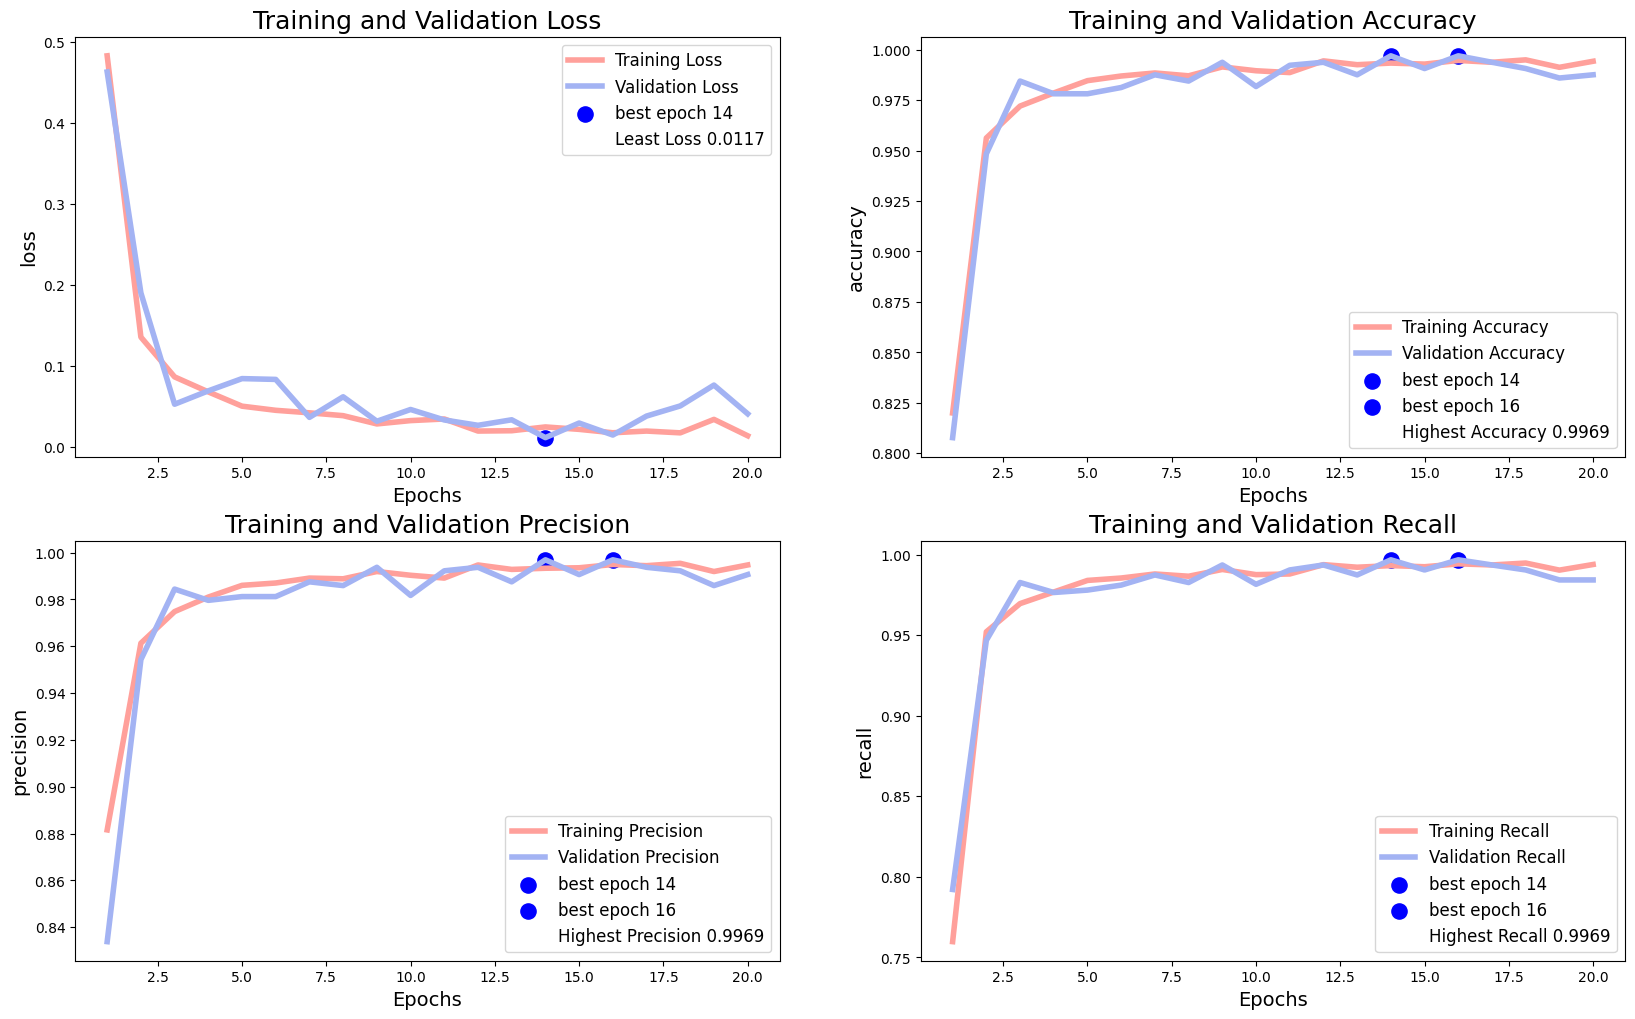

In [34]:
TRAIN_CLR = '#FFA09B'
VAL_CLR  = '#A3B3F3'
BEST_CLR = 'b'

plt.style.reload_library()
epochs = [i for i in range(1, len(hist['loss'])+1)]
plt.figure(figsize=(20, 12))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    train_values = hist[m]
    val_values = hist[f'val_{m}']
    if m == 'loss':
        best_value = np.min(val_values)
    else:
        best_value = np.max(val_values)
    best_epochs = [j for j, v in enumerate(val_values) if v == best_value]

    plt.subplot(2, 2, i+1)
    plt.plot(epochs, train_values, color=TRAIN_CLR, label = f"Training {m.capitalize()}", linewidth=4)
    plt.plot(epochs, val_values, color=VAL_CLR, label = f"Validation {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Training and Validation {m.capitalize()}", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

# Testing

In [12]:
from keras.models import load_model
directory = r'./Models/Xception/wave_2'

scores = {'loss': [], 'accuracy': [], 'precision': [], 'recall':[]}
for path in os.listdir(directory):
    if path.endswith('.keras'):
        mod = load_model(os.path.join(directory, path))
        score = mod.evaluate(train_generator, verbose=0)
        for i, key in enumerate(scores.keys()):
            scores[key].append(score[i])


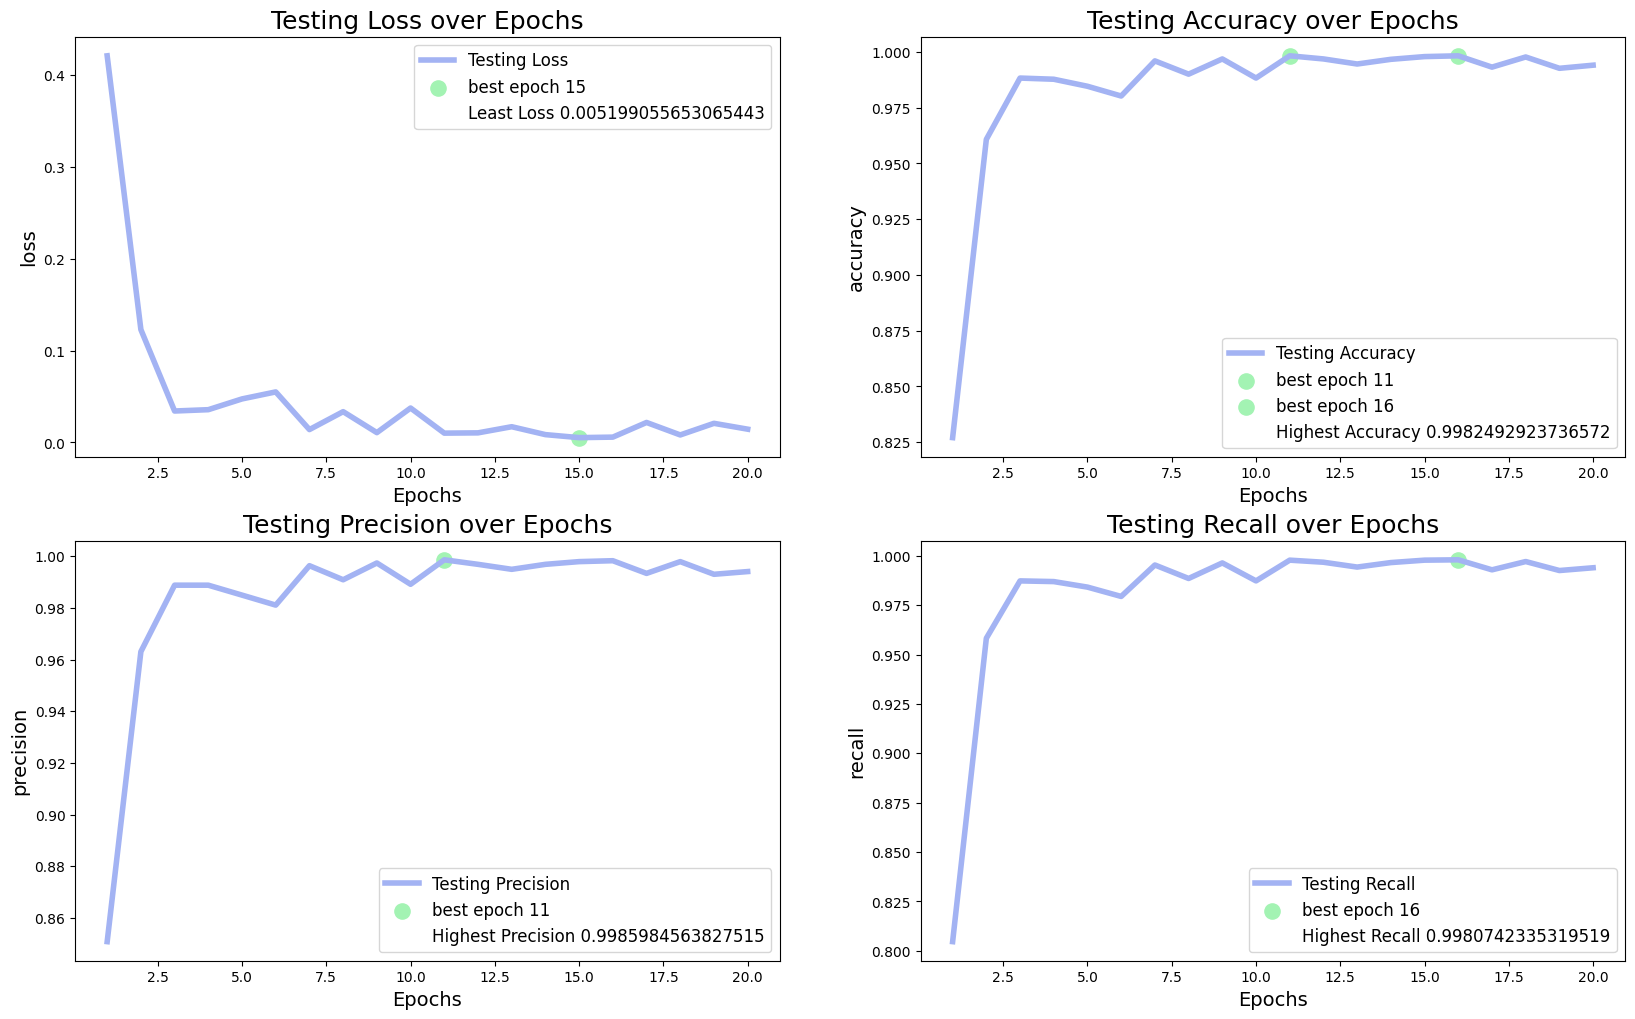

In [20]:
TEST_CLR  = '#A3B3F3'
BEST_CLR = '#A3F3B3'

epochs = [i for i in range(1, len(scores['loss'])+1)]
plt.figure(figsize=(20, 12))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    values = scores[m]
    if m == 'loss':
        best_value = np.min(values)
    else:
        best_value = np.max(values)
    best_epochs = [j for j, v in enumerate(values) if v == best_value]

    plt.subplot(2, 2, i+1)
    plt.plot(epochs, values, color=TEST_CLR, label = f"Testing {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Testing {m.capitalize()} over Epochs", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

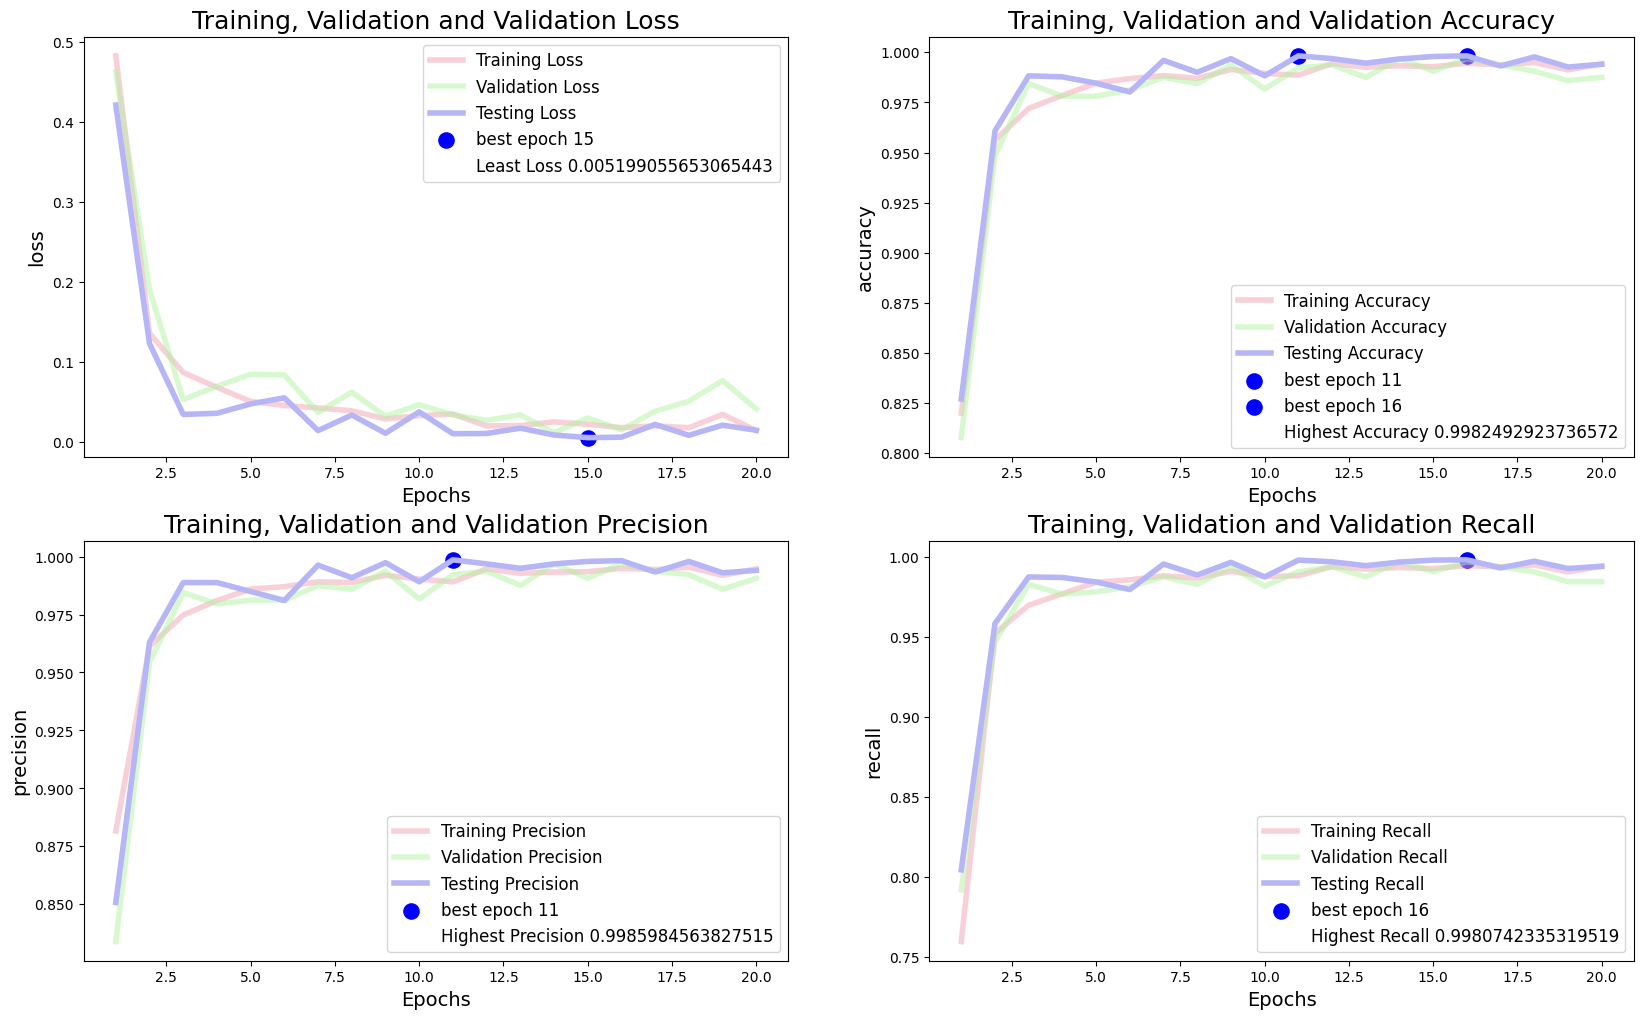

In [30]:
TRAIN_CLR = '#F3A3B3'
VAL_CLR  = '#B3F3A3'
TEST_CLR  = '#B6B6F6'
BEST_CLR = 'b'

plt.style.reload_library()
epochs = [i for i in range(1, len(hist['loss'])+1)]
plt.figure(figsize=(20, 12))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    train_values = hist[m]
    val_values = hist[f'val_{m}']
    test_values = scores[m]
    if m == 'loss':
        best_value = np.min(test_values)
    else:
        best_value = np.max(test_values)
    best_epochs = [j for j, v in enumerate(test_values) if v == best_value]

    plt.subplot(2, 2, i+1)
    plt.plot(epochs, train_values, color=TRAIN_CLR, label = f"Training {m.capitalize()}", linewidth=4, alpha=0.5)
    plt.plot(epochs, val_values, color=VAL_CLR, label = f"Validation {m.capitalize()}", linewidth=4, alpha=0.5)
    plt.plot(epochs, test_values, color=TEST_CLR, label = f"Testing {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Training, Validation and Validation {m.capitalize()}", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

In [12]:
import tensorflow as tf

In [13]:
def grad_cam(model, image, last_conv_layer_name, class_idx=None):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

In [15]:
def display_grad_cam(image_path, heatmap, alpha=0.6):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.grid(False)
    plt.title("Normal Image", fontdict={'size': 10})

    img = load_img(image_path)
    img = img_to_array(img) / 255.0
    plt.imshow(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1]))
    heatmap = tf.image.grayscale_to_rgb(heatmap)

    superimposed_img = heatmap * alpha + img
    plt.subplot(1, 2, 2)
    plt.title(f"Heat Map with Alpha {alpha}", fontdict={'size': 10})
    plt.imshow(superimposed_img / np.max(superimposed_img))
    plt.axis('off')
    plt.show()

In [16]:
image_path = r"./Dataset/Training\glioma\Tr-glTr_0003.jpg"
# last_conv_layer_name = "conv5_block3_out"
last_conv_layer_name = "block1_conv2_act"

processed_image = preprocess_image(image_path)

heatmap = grad_cam(model, processed_image, last_conv_layer_name)

display_grad_cam(image_path,
 heatmap, alpha=1)

NameError: name 'model' is not defined

In [36]:
from keras.models import load_model
model = load_model('Models\Xception\wave_1\model_epoch_41.keras')

In [20]:
def get_layer_vision(model, image_path, save_path = None, alpha=1):

    plt.figure(figsize=(13, 70))
    plt.subplot(28, 5, 1)

    img = load_img(image_path)
    img = img_to_array(img) / 255.0
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image", fontdict={'size': 10})


    processed_image = preprocess_image(image_path)
    for i, layer in enumerate(model.layers[2:]):
        try:
            heatmap = grad_cam(model, processed_image, layer.name)
            heatmap = np.uint8(255 * heatmap)
            heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1]))
            heatmap = tf.image.grayscale_to_rgb(heatmap)

            superimposed_img = heatmap * alpha + img
            plt.subplot(28, 5, i+2)
            plt.imshow(superimposed_img / np.max(superimposed_img))
            plt.title(layer.name,fontdict={'size':10})
            plt.axis('off')

        except:
            pass
    
    if save_path:
        plt.savefig(save_path)

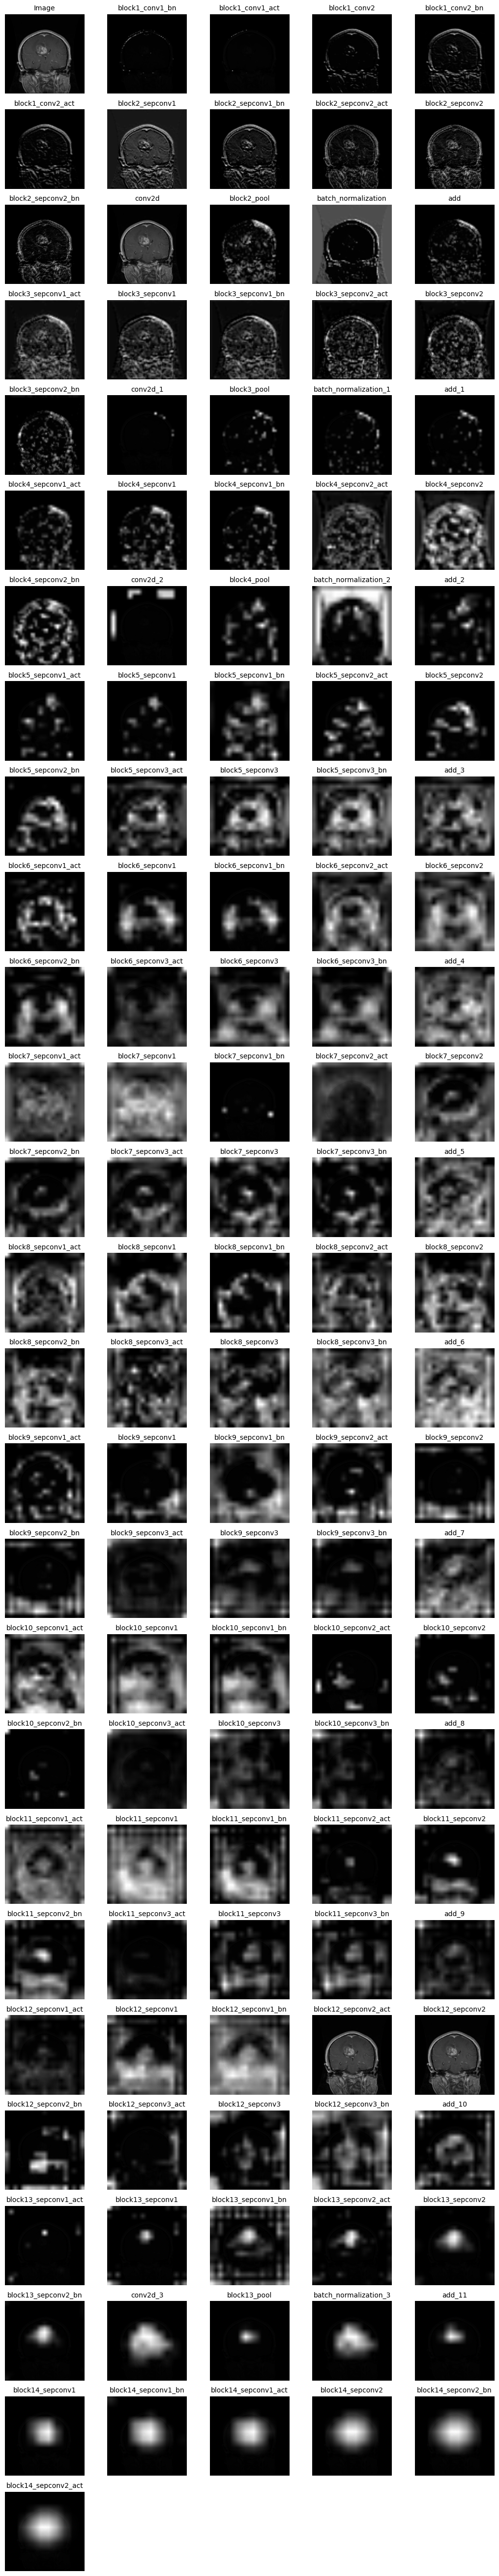

In [23]:
get_layer_vision(model, r'Dataset\Testing\glioma\Te-gl_0040.jpg', alpha=0.1)

In [ ]:
last_conv_layer_name = "block1_conv2_act"

processed_image = preprocess_image(image_path)

heatmap = grad_cam(model, processed_image, last_conv_layer_name)

display_grad_cam(image_path,
 heatmap, alpha=1)

# Testing

In [79]:
test_score = model.evaluate(test_generator, verbose=0)

In [81]:
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

Test Loss: 0.2040
Test Accuracy: 92.52%


In [87]:
class_indices = train_generator.class_indices


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [96]:
import numpy as np
def classify(img_path):
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    img = Image.open(img_path)

    resized_img = img.resize((299, 299))
    if img.mode != 'RGB':
        img = np.stack([np.array(resized_img)] * 3, axis=-1)
    else:
        img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    predictions = model.predict(img)
    probs = list(predictions[0])

    return classes[np.argmax(probs)]

In [97]:
classify('Dataset/Testing/glioma/Te-gl_0044.jpg')

1/1 [==============================] - 0s 18ms/step


'glioma'

In [98]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
def vectorize(label):
    return classes.index(label)

In [100]:
test_classes = [vectorize(c) for c in df["Class"]]
pred_classes = [vectorize(classify(p)) for p in df["Image"] ]

1/1 [==============================] - 0s 19ms/step


In [101]:
from sklearn.metrics import classification_report

print(classification_report(test_classes, pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       300
           1       0.86      0.79      0.83       306
           2       0.95      0.98      0.97       405
           3       0.91      0.98      0.94       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311



Text(50.58333333333332, 0.5, 'Truth Tabel')

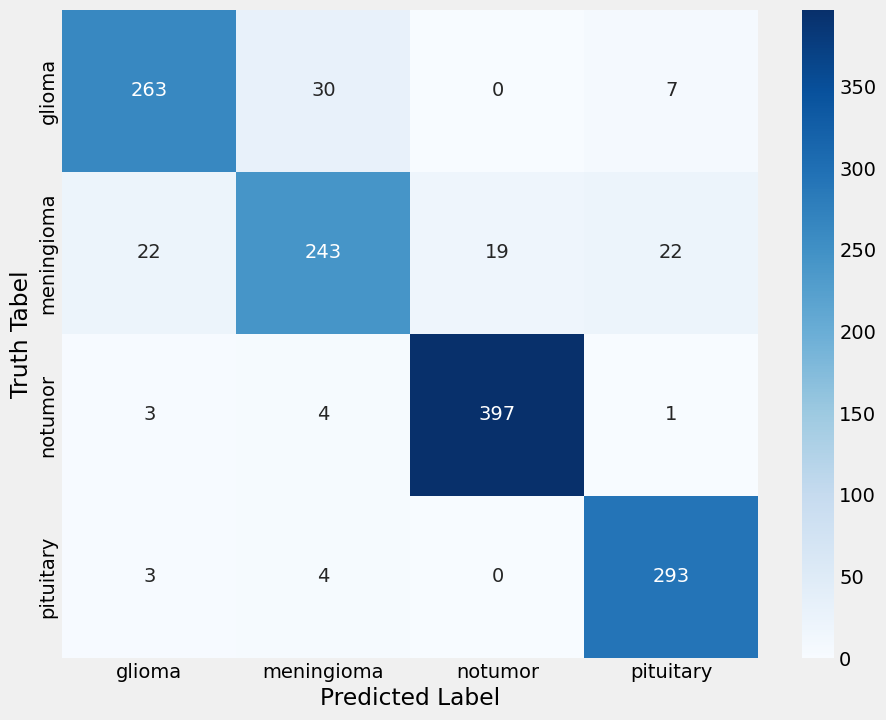

In [102]:
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import heatmap

cm = confusion_matrix(test_classes, pred_classes)
labels = classes
plt.figure(figsize=(10, 8))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Tabel')